# 0. Environment, Package, Configuration, Seed, CUDA

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertTokenizer, BertForSequenceClassification, get_linear_schedule_with_warmup
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
import pandas as pd
import numpy as np
import time
import datetime
import random
import os
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

In [2]:
CONFIG = {
    'seed': 42,
    'batch_size': 32,
    'max_len': 128,
    'epochs': 3,
    'lr': 2e-5,
    'eps': 1e-8,
    'warmup_ratio': 0.1,
    'model_name': 'bert-base-multilingual-cased',
    'train_path': 'dataset/processed/train.csv',
    'test_path': 'dataset/processed/test.csv'
}

In [3]:
# Set random seed (Reproducibility)
def set_seed(seed_value):
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)

set_seed(CONFIG['seed'])
print('Set seed to %d.' % CONFIG['seed'])

Set seed to 42.


In [4]:
# check CUDA
if torch.cuda.is_available():    
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('Using the GPU:', torch.cuda.get_device_name(0))
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
Using the GPU: NVIDIA GeForce GTX 1060 6GB


# 1. Loading and Preprocessing Data

In [5]:
train_df = pd.read_csv(CONFIG['train_path'])
print('Number of samples: ', len(train_df))
train_df.head()

Number of samples:  14691


,Comment,Sentiment
0,it’s so adorable that he says “baap” for up an...,positive
1,sir i have no words to describe your teaching ...,positive
2,the reason they said large and open space inst...,neutral
3,for ur information this is an fact that jrntr ...,neutral
4,you can really tell the progress awesome espec...,positive


In [6]:
test_df = pd.read_csv(CONFIG['test_path'])
print('Number of samples: ', len(test_df))
test_df.head()

Number of samples:  3673


,Comment,Sentiment
0,“oh my god guys there’s an octopus eating a cr...,negative
1,my daughter will be starting her 8th grade che...,positive
2,for some future video you should definitely bu...,neutral
3,i’m chronically ill and very frequently find i...,positive
4,the pizza planet pizza being awful is just dis...,negative


In [7]:
# Define label Mapping
label_map = {
    'negative': 0,
    'neutral': 1,
    'positive': 2
}

# convert label
def convert_label(df):
    df['label'] = df['Sentiment'].map(label_map)
    df = df.dropna(subset=['label']) # remove uncovered label (e.g., 'Other')
    df['label'] = df['label'].astype(int)
    return df

train_df = convert_label(train_df)
test_df = convert_label(test_df)

In [8]:
train_texts = train_df["Comment"].values
train_labels = train_df["label"].values
test_texts = test_df["Comment"].values
test_labels = test_df["label"].values

In [9]:
print(f"  Train rows: {len(train_df)}")
print(f"  Train class distribution: {train_df['label'].value_counts().to_dict()}")
print(f"  Test rows: {len(test_df)}")
print(f"  Test class distribution: {test_df['label'].value_counts().to_dict()}")

  Train rows: 14691
  Train class distribution: {2: 9121, 1: 3700, 0: 1870}
  Test rows: 3673
  Test class distribution: {2: 2281, 1: 925, 0: 467}


# 2. Train / Validation Split (with Stratify)

In [10]:
X_train, X_val, y_train, y_val = train_test_split(
    train_texts,
    train_labels,
    test_size=0.2,
    random_state=CONFIG['seed'],
    stratify=train_labels
)

print(f"Train: {len(X_train)}")
print(f"Val:   {len(X_val)}")
print(f"Test:  {len(test_texts)}")

Train: 11752
Val:   2939
Test:  3673


In [11]:
classes = np.unique(y_train)
class_weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)
print('Class weights:', {int(i): float(w) for i, w in enumerate(class_weights.cpu().numpy())})


Class weights: {0: 2.6185383796691895, 1: 1.3234233856201172, 2: 0.5369151830673218}


# 3. Tokenization (using Multilingual model)

In [12]:
tokenizer = BertTokenizer.from_pretrained(CONFIG['model_name'])

def encode_texts(texts):
    encoded_batch = tokenizer(
        texts.tolist() if isinstance(texts, np.ndarray) else list(texts),
        add_special_tokens=True,
        max_length=CONFIG['max_len'],
        padding='max_length',
        truncation=True,
        return_attention_mask=True,
        return_tensors='pt'
    )
    return encoded_batch['input_ids'], encoded_batch['attention_mask']

train_inputs, train_masks = encode_texts(X_train)
validation_inputs, validation_masks = encode_texts(X_val)
test_inputs, test_masks = encode_texts(test_texts)

train_labels = torch.tensor(y_train)
validation_labels = torch.tensor(y_val)
test_labels = torch.tensor(test_labels)


In [13]:
# Building Training DataLoader
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=CONFIG['batch_size'])

# Building Validation DataLoader
validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=CONFIG['batch_size'])

# Building Test DataLoader
test_data = TensorDataset(test_inputs, test_masks, test_labels)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=CONFIG['batch_size'])

# 4. Model Initialization


In [14]:
model = BertForSequenceClassification.from_pretrained(
    CONFIG['model_name'], 
    num_labels = 3, 
    output_attentions = False, 
    output_hidden_states = False, 
)

model.cuda()

optimizer = torch.optim.AdamW(model.parameters(), lr=CONFIG['lr'], eps=CONFIG['eps'])
total_steps = len(train_dataloader) * CONFIG['epochs']
num_warmup_steps = int(total_steps * CONFIG['warmup_ratio'])
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=num_warmup_steps, num_training_steps=total_steps)

loss_fn = nn.CrossEntropyLoss(weight=class_weights)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


# 5. Training Loop

In [15]:
def format_time(elapsed):
    elapsed_rounded = int(round((elapsed)))
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [16]:
print("Start Training...")
training_stats = []
total_t0 = time.time()

for epoch_i in range(0, CONFIG['epochs']):
    
    # --- Training ---
    print(f'\n======== Epoch {epoch_i + 1} / {CONFIG["epochs"]} ========')
    t0 = time.time()
    total_train_loss = 0
    model.train()

    progress_bar = tqdm(train_dataloader, desc=f"Epoch {epoch_i+1} Training", leave=False)

    for step, batch in enumerate(progress_bar):
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        model.zero_grad()

        # Forward Pass
        outputs = model(b_input_ids, 
                       token_type_ids=None, 
                       attention_mask=b_input_mask, 
                       return_dict=True)

        logits = outputs.logits
        loss = loss_fn(logits, b_labels)
        total_train_loss += loss.item()
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()

        progress_bar.set_postfix({'loss': f'{loss.item():.4f}'})

    avg_train_loss = total_train_loss / len(train_dataloader)         
    training_time = format_time(time.time() - t0)
    print(f"Training Loss: {avg_train_loss:.2f} | Time: {training_time}")

    
    # --- Validation ---
    t0 = time.time()
    model.eval()
    total_eval_accuracy = 0
    total_eval_loss = 0

    for batch in validation_dataloader:
        
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
        with torch.no_grad():        
            outputs = model(b_input_ids, 
                           token_type_ids=None, 
                           attention_mask=b_input_mask,
                           return_dict=True)

        logits = outputs.logits
        loss = loss_fn(logits, b_labels)
        total_eval_loss += loss.item()
        
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Compute Accuracy
        pred_flat = np.argmax(logits, axis=1).flatten()
        labels_flat = label_ids.flatten()
        total_eval_accuracy += np.sum(pred_flat == labels_flat) / len(labels_flat)
        

    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    avg_val_loss = total_eval_loss / len(validation_dataloader)
    val_time = format_time(time.time() - t0)
    print(f"Val Loss: {avg_val_loss:.2f} | Val Accuracy: {avg_val_accuracy:.2f} | Time: {val_time}")

    

print(f"\nTotal Training Time: {format_time(time.time()-total_t0)}")


Start Training...

======== Epoch 1 / 3 ========


Epoch 1 Training:   0%|          | 0/368 [00:00<?, ?it/s]

Training Loss: 0.77 | Time: 0:05:58
Val Loss: 0.59 | Val Accuracy: 0.76 | Time: 0:00:29

======== Epoch 2 / 3 ========


Epoch 2 Training:   0%|          | 0/368 [00:00<?, ?it/s]

Training Loss: 0.48 | Time: 0:05:58
Val Loss: 0.60 | Val Accuracy: 0.79 | Time: 0:00:31

======== Epoch 3 / 3 ========


Epoch 3 Training:   0%|          | 0/368 [00:00<?, ?it/s]

Training Loss: 0.32 | Time: 0:05:57
Val Loss: 0.66 | Val Accuracy: 0.81 | Time: 0:00:32

Total Training Time: 0:19:24


# 6. Test Set Evaluation

In [17]:
print("Running Final Test Set Evaluation...")

model.eval()
test_preds = []
test_true_labels = []
test_probs = []

for batch in tqdm(test_dataloader, desc="Testing"):
    
    b_input_ids = batch[0].to(device)
    b_input_mask = batch[1].to(device)
    b_labels = batch[2].to(device)
    
    with torch.no_grad():        
        result = model(b_input_ids, 
                       token_type_ids=None, 
                       attention_mask=b_input_mask,
                       labels=b_labels,
                       return_dict=True)

    logits = result.logits.detach().cpu()
    probs = torch.softmax(logits, dim=1).numpy()
    test_probs.extend(probs)

    logits = logits.numpy()
    label_ids = b_labels.to('cpu').numpy()
    
    test_preds.extend(np.argmax(logits, axis=1).flatten())
    test_true_labels.extend(label_ids.flatten())

final_accuracy = accuracy_score(test_true_labels, test_preds)
print(f"Test Accuracy: {final_accuracy:.4f}")

print("Test Set Classification Report:")
print(classification_report(test_true_labels, test_preds, digits=4, target_names=['negative', 'neutral', 'positive']))

Running Final Test Set Evaluation...


Testing:   0%|          | 0/115 [00:00<?, ?it/s]

Test Accuracy: 0.8130
Test Set Classification Report:
              precision    recall  f1-score   support

    negative     0.6576    0.7281    0.6911       467
     neutral     0.6650    0.7254    0.6939       925
    positive     0.9199    0.8658    0.8921      2281

    accuracy                         0.8130      3673
   macro avg     0.7475    0.7731    0.7590      3673
weighted avg     0.8224    0.8130    0.8166      3673




Confusion Matrix (rows = true, cols = predicted):
[[0.72805139 0.17987152 0.09207709]
 [0.13513514 0.72540541 0.13945946]
 [0.02279702 0.11135467 0.86584831]]


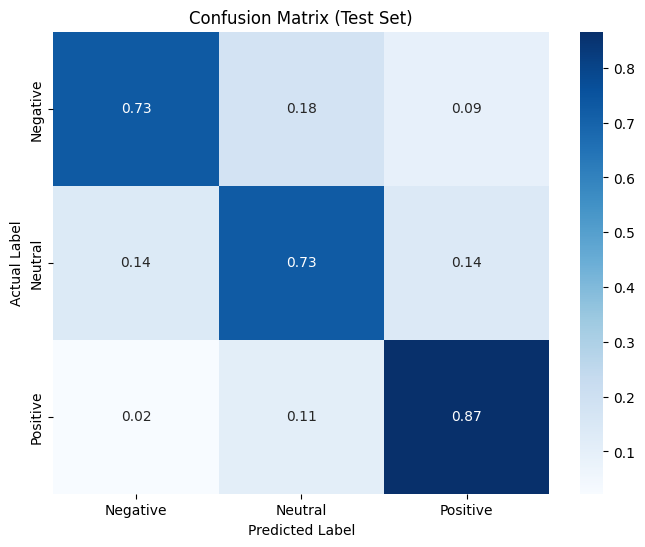

In [21]:
cm = confusion_matrix(test_true_labels, test_preds, normalize='true')
print("\nConfusion Matrix (rows = true, cols = predicted):")
print(cm)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues', 
            xticklabels=['Negative', 'Neutral', 'Positive'],
            yticklabels=['Negative', 'Neutral', 'Positive'])
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix (Test Set)')
plt.show()

In [22]:
# === Saving the prediction on Test set into CSV ===

X_test = test_texts
# Convert test_labels to numpy array if needed
if torch.is_tensor(test_labels):
    y_test = test_labels.cpu().numpy()
else:
    y_test = np.asarray(test_labels)

# make sure X_test / y_test and test_preds have same len
print("len(X_test):", len(X_test))
print("len(y_test):", len(y_test))
print("len(test_preds):", len(test_preds))

prob_array = np.asarray(test_probs)

pred_df = pd.DataFrame({
    "id": range(len(X_test)),
    "comment": X_test,
    "true_label": y_test.astype(int),
    "pred_label": np.asarray(test_preds, dtype=int)
})

for i in range(prob_array.shape[1]):
    pred_df[f"prob_{i}"] = prob_array[:, i]

output_path = f"outputs/bert/test_predictions_rs{CONFIG['seed']}.csv"
os.makedirs(os.path.dirname(output_path), exist_ok=True)
pred_df.to_csv(output_path, index=False)
print(f"Saved: {output_path}")
pred_df.head()


len(X_test): 3673
len(y_test): 3673
len(test_preds): 3673
Saved: outputs/bert/test_predictions_rs42.csv


,id,comment,true_label,pred_label,prob_0,prob_1,prob_2
0,0,“oh my god guys there’s an octopus eating a cr...,0,1,0.110848,0.834722,0.054430
1,1,my daughter will be starting her 8th grade che...,2,2,0.004577,0.047063,0.948360
2,2,for some future video you should definitely bu...,1,1,0.096969,0.883732,0.019299
3,3,i’m chronically ill and very frequently find i...,2,2,0.010083,0.032405,0.957511
4,4,the pizza planet pizza being awful is just dis...,0,1,0.338372,0.571973,0.089654
